# Libraries

In [42]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, mean_squared_error, make_scorer,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

import nltk
from nltk.corpus import stopwords


# Read Dataset

In [21]:
raw_df = pd.read_csv('train-balanced-sarcasm.csv')
raw_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


# Data-preprocessing 

## Drop Features

Irrelevant: author, date, created_utc

In [22]:
# Drop NAs
raw_df.dropna(inplace=True)

# Select 100000 rows of sample
# Reset index so the cross validation later won't go wrong
filter_df = raw_df.sample(n=100000, random_state=000).reset_index(drop=True)

# Drop irrelevant features
filter_df.drop(['author', 'date', 'created_utc'],axis=1)

# Data is balance, do not need oversampling
print(filter_df['label'].value_counts()) 

# Show the data
filter_df.head()

0    50016
1    49984
Name: label, dtype: int64


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,"The title of this article should be: ""How to n...",xNOM,MensRights,1,1,0,2014-11,2014-11-07 11:48:34,You can approach women without being creepy
1,0,What a wasted opportunity... at least be funny...,Jacked1218,MMA,5,5,0,2016-07,2016-07-05 22:06:19,Nate Diaz Snapchat Hacked
2,1,But....but... sodium!,Chicup,fatlogic,1,1,0,2015-03,2015-03-09 13:16:40,Canned soups have been hugely helpful for the ...
3,1,"Yeah, we need more animosity between nations.",Bloodysneeze,worldnews,1,1,0,2013-07,2013-07-09 15:20:36,It really sounds like all the English speaking...
4,0,uuugh,name032282,Minecraft,2,2,0,2011-04,2011-04-02 04:50:42,Has anyone held a doggy funeral on their serve...


## Categorical Process

Transform comments into TF-IDF vectors

In [23]:
# Instantiate the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Fit and transform the processed comments and parent_comment
tfidf_comment = tfidf_vectorizer.fit_transform(filter_df['comment'])
tfidf_parent_comment = tfidf_vectorizer.fit_transform(filter_df['parent_comment'])

# Display the shape of the resulting TF-IDF feature matrix
print(tfidf_comment.shape)
print(tfidf_parent_comment.shape)

(100000, 436490)
(100000, 899057)


We have got a comment TF-IDF matrix, containing 100000 rows and 436490 features
We have got a parent_comment TF-IDF matrix, containing 100000 rows and 899057 features

Transform categorical "subreddit" to dummy

In [24]:
categorical_columns = ['subreddit']
for i in categorical_columns: 
    filter_df = pd.concat([filter_df,pd.get_dummies(filter_df[i],drop_first=True, prefix=i)],axis=1)
    filter_df = filter_df.drop(i,axis=1)
    
filter_df.shape

(100000, 5594)

## Split Dataset

In [25]:
# Y is the response variable
Y = filter_df['label']

# X is the features
X = tfidf_comment

# Split the data (Train 0.8, Test 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=000)

## K-Fold CV Setup

In [26]:
# Set up K-Fold Cross Validation 
n_splits = 5
shuffle = True
random_state = 000
cv = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

## A Function to Create Dictionary

In [27]:
def create_dictionary(param_1,param_2):
    result_dictionary = {} 
    for i in param_1: 
        result_dictionary[i] = {} 
        for j in param_2: 
                result_dictionary[i][j] = {} 
    return result_dictionary

## Random Forest

Random Forest Cross Validation

In [30]:
# CV in Trees
# Set Hyperparameter (Lambda) values to cross validate
max_depth = [2, 5, 10, 15, 20, 25]
number_of_trees = [50, 100, 150, 200]

cross_validate_result = create_dictionary(number_of_trees, max_depth)
cross_validate_recall = create_dictionary(number_of_trees, max_depth)
cross_validate_precision = create_dictionary(number_of_trees, max_depth)
cross_validate_mse = create_dictionary(number_of_trees, max_depth)

for tree in number_of_trees:
    for depth in max_depth:
        print('Depth of Tree : ', depth, ' Number of Trees ', tree)

        accuracies = []
        recall_scores = []
        precision_scores = []
        mse_scores = []

        random_forest_cv = RandomForestClassifier(n_estimators=tree, max_depth=depth)

        for train_index, test_index in cv.split(X):
            # change to loc to define the rows in the dataframe
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            Y_cv_train, Y_cv_test = Y[train_index], Y[test_index]

            random_forest_cv.fit(X_cv_train, Y_cv_train)
            Y_pred = random_forest_cv.predict(X_cv_test)

            # Cross-Validation Prediction Error
            score = random_forest_cv.score(X_cv_test, Y_cv_test)
            accuracies.append(score)
            recall_scores.append(recall_score(Y_cv_test, Y_pred))
            precision_scores.append(precision_score(Y_cv_test, Y_pred))
            mse_scores.append(mean_squared_error(Y_cv_test, Y_pred))

        cross_validate_result[tree][depth] = (sum(accuracies) / len(accuracies))
        cross_validate_recall[tree][depth] = (sum(recall_scores) / len(recall_scores))
        cross_validate_precision[tree][depth] = (sum(precision_scores) / len(precision_scores))
        cross_validate_mse[tree][depth] = (sum(mse_scores) / len(mse_scores))

        print("Accuracy : " + str((sum(accuracies) / len(accuracies))))
        print("Precision : " + str((sum(recall_scores) / len(recall_scores))))
        print("Recall : " + str((sum(precision_scores) / len(precision_scores))))
        print("MSE : " + str((sum(mse_scores) / len(mse_scores))))
        print()

# Dictionary Summary
print('------------------')
print('Accuracy : ', cross_validate_result)
print('Precision : ', cross_validate_precision)
print('Recall : ', cross_validate_recall)
print('MSE : ', cross_validate_mse)

Depth of Tree :  2  Number of Trees  50
Accuracy : 0.54707
Precision : 0.3497665877331726
Recall : 0.6480501329513654
MSE : 0.45293

Depth of Tree :  5  Number of Trees  50
Accuracy : 0.5984299999999999
Precision : 0.4064061753485966
Recall : 0.6625697991611792
MSE : 0.4015700000000001

Depth of Tree :  10  Number of Trees  50
Accuracy : 0.6196699999999999
Precision : 0.4719248834190385
Recall : 0.6713424965180559
MSE : 0.38032999999999995

Depth of Tree :  15  Number of Trees  50
Accuracy : 0.6368199999999999
Precision : 0.49090791758730834
Recall : 0.6940323393946181
MSE : 0.36318

Depth of Tree :  20  Number of Trees  50
Accuracy : 0.64028
Precision : 0.5203367211482168
Recall : 0.685436572731217
MSE : 0.35972

Depth of Tree :  25  Number of Trees  50
Accuracy : 0.64246
Precision : 0.5168964528080917
Recall : 0.6904486342214683
MSE : 0.35753999999999997

Depth of Tree :  2  Number of Trees  100
Accuracy : 0.5593600000000001
Precision : 0.5083942853203653
Recall : 0.6233498967975446


Plot

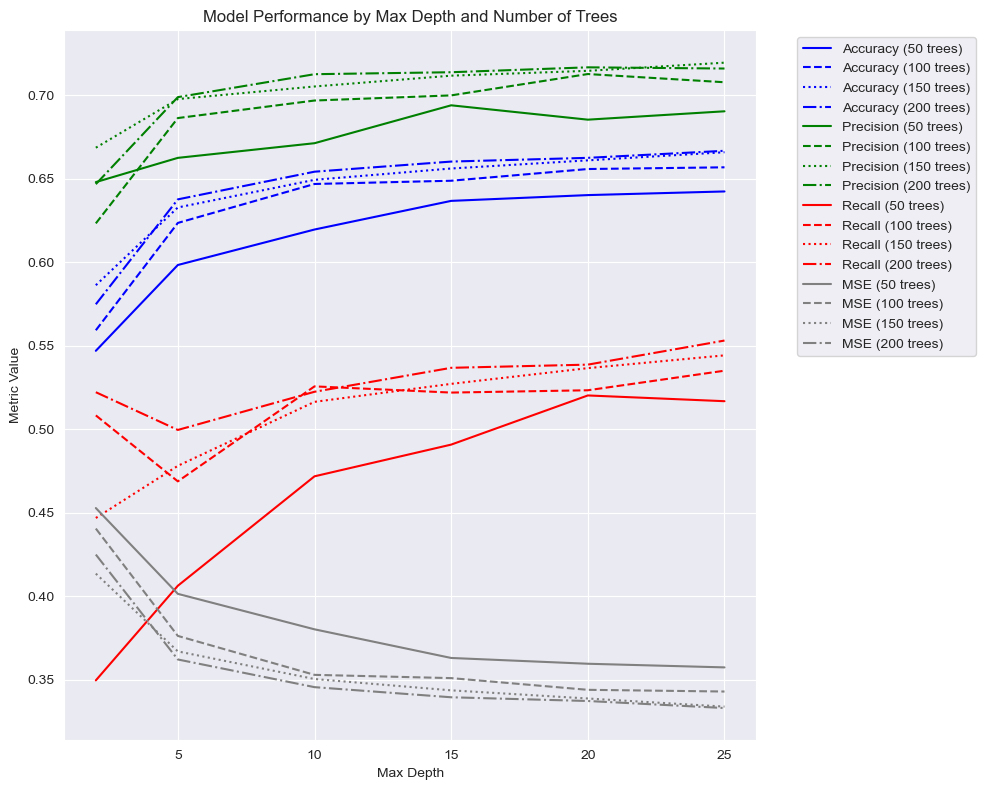

In [31]:
plt.figure(figsize=(10, 8))

# Define line styles and colors for different number of trees
line_styles = {50: 'solid', 100: 'dashed', 150: 'dotted', 200: 'dashdot'}
colors = {'Accuracy': 'blue', 'Precision': 'green', 'Recall': 'red', 'MSE': 'grey'}

# Consolidate plotting data
metrics = {
    'Accuracy': cross_validate_result,
    'Precision': cross_validate_precision,
    'Recall': cross_validate_recall,
    'MSE': cross_validate_mse,
}

# Plotting
for metric_name, metric_data in metrics.items():
    for num_trees, depths in metric_data.items():
        plt.plot(max_depth, [depths[depth] for depth in max_depth],
                 label=f'{metric_name} ({num_trees} trees)',
                 linestyle=line_styles[num_trees],
                 color=colors[metric_name])

plt.title('Model Performance by Max Depth and Number of Trees')
plt.xlabel('Max Depth')
plt.ylabel('Metric Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

After selected the best parameter, rerun the random forest

In [32]:
random_forest = RandomForestClassifier(n_estimators = 200, max_depth=10, random_state=0)
random_forest.fit(X, Y)

y_pred = random_forest.predict(X_test)
print("RND Forest Accuracy : " , accuracy_score(y_test, y_pred))
print("RND Forest Recall : " , recall_score(y_test, y_pred))
print("RND Forest Precision : ", precision_score(y_test,y_pred))
print("RND Forest F1 : ", f1_score(y_test,y_pred))
print("RND Forest MSE : ", mean_squared_error(y_test,y_pred))

RND Forest Accuracy :  0.67955
RND Forest Recall :  0.54134739775102
RND Forest Precision :  0.7513812154696132
RND Forest F1 :  0.6293018682399214
RND Forest MSE :  0.32045


Extract the random forest coefficient to see its importance

In [46]:
# Get Feature Importance
importance = random_forest.feature_importances_

# Get Feature Name
feature_names = tfidf_vectorizer.get_feature_names_out()

# Pair Feature Importance and Name
features_importance = zip(feature_names, importance)

# Sort feature by importance
sorted_features = sorted(features_importance, key=lambda x: x[1], reverse=True)

# Get first 50
for feature, importance in sorted_features[:100]:
    print(f"{feature}: {importance}")

yeah: 0.018067620033052803
obviously: 0.013952278437304124
we: 0.013840174074728347
because: 0.011683601548443914
right: 0.010402768643062815
all: 0.00915259126627523
totally: 0.00870759920733005
are: 0.008363286304726193
but: 0.00819573069360325
everyone: 0.007905753745770731
yeah because: 0.007071849573782988
dropped this: 0.006161003738678179
you forgot: 0.006098612167178326
racist: 0.005876114716183946
sure: 0.005719511660068971
should: 0.005637473798108182
white: 0.005445803195259783
you: 0.005427689884951107
must be: 0.005414044153339989
also: 0.005401172948322826
we should: 0.005234148684748423
must: 0.005175563723156406
wow: 0.005164909455506009
my: 0.005116097524785196
thank: 0.005015507141179427
because that: 0.004889067697284597
just: 0.004809951815977462
only: 0.0045756548450866154
well: 0.004410756894164095
women: 0.00424256912683314
not like: 0.004037413166168638
was: 0.004000545083574339
as: 0.003863166476887854
dare: 0.003846247742836527
no: 0.003742939840902786
be: 0.0

Eliminate Stop Words

In [47]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Filter Stop Words
filtered_features = [(feature, importance) for feature, importance in sorted_features if feature not in stop_words]

# Print Filtered Features
for feature, importance in filtered_features[:100]: # Get First 100
    print(f"{feature}: {importance}")

yeah: 0.018067620033052803
obviously: 0.013952278437304124
right: 0.010402768643062815
totally: 0.00870759920733005
everyone: 0.007905753745770731
yeah because: 0.007071849573782988
dropped this: 0.006161003738678179
you forgot: 0.006098612167178326
racist: 0.005876114716183946
sure: 0.005719511660068971
white: 0.005445803195259783
must be: 0.005414044153339989
also: 0.005401172948322826
we should: 0.005234148684748423
must: 0.005175563723156406
wow: 0.005164909455506009
thank: 0.005015507141179427
because that: 0.004889067697284597
well: 0.004410756894164095
women: 0.00424256912683314
not like: 0.004037413166168638
dare: 0.003846247742836527
all the: 0.0036529438335101212
course: 0.003631741457317129
cause: 0.003567006435404559
they re: 0.0035508241118378837
us: 0.003425875394138583
yeah but: 0.0033754983690966723
don you: 0.0033515845451091157
usually: 0.0032183910378324964
right because: 0.0031942091389174643
clearly the: 0.003142262663749498
one: 0.003118524285933092
you dropped: 0

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\16920\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
